# Neural Network - 2-Hourly Demand Prediction

In this section we predict the 2-hourly demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- Hexagons with low resolution
- Hexagons with medium resolution
- Hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

Our procedure in this part is structured in the following way:

- Explore different Neural Network architectures to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best Neural Network Architecture
- Make predictions for all spatial units with the Architecture winner of the Hyperparametertuning
- Evaluation

<hr style="border: 1px solid #8888;">

In [1]:
#pip install keras_tuner

In [2]:
# Import all necessary packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import loguniform
import predictive as pred
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, max_error
import os.path

# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

<hr style="border: 1px solid #8888;">

## Preprocessing

In [3]:
# import datasets
df_2h_comar = pd.read_csv("../data/datasets/df_2h_comar.csv")
df_2h_hexlow = pd.read_csv("../data/datasets/df_2h_hexlow.csv")
df_2h_hexmed = pd.read_csv("../data/datasets/df_2h_hexmed.csv")
df_2h_hexhig = pd.read_csv("../data/datasets/df_2h_hexhig.csv")

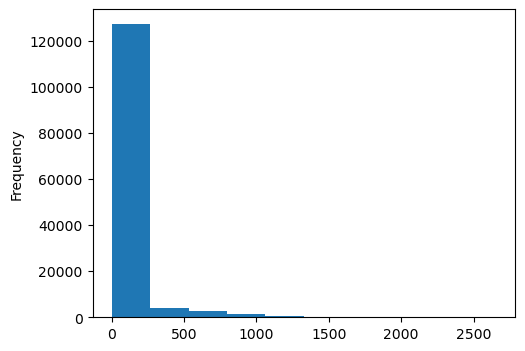

In [4]:
plt.figure(figsize=(12,4)) 

plt.subplot(121)  
df_2h_comar['numOfTaxis_area'].plot.hist()

#plt.subplot(122)
#df_2h_comar['numOfTaxis_area'] = np.log(df_2h_comar['numOfTaxis_area'])
#df_2h_comar['numOfTaxis_area'].plot.hist()
plt.show()

Even if the distribution does not look good, we do not use the log transformation at this point, because only simple neural networks benefit from it, but more complex ones even become worse (**we have tested this!**).

In [5]:
#df_2h_hexlow['numOfTaxis_area'] = np.log(df_2h_hexlow['numOfTaxis_area'])
#df_2h_hexmed['numOfTaxis_area'] = np.log(df_2h_hexmed['numOfTaxis_area'])
#df_2h_hexhig['numOfTaxis_area'] = np.log(df_2h_hexhig['numOfTaxis_area'])

In [6]:
df_2h_comar.drop(columns = ['date_start'],inplace = True)
df_2h_hexlow.drop(columns = ['date_start'],inplace = True)
df_2h_hexmed.drop(columns = ['date_start'],inplace = True)
df_2h_hexhig.drop(columns = ['date_start'],inplace = True)

In [7]:
df_2h_comar = pred.dayandseas_to_int(df_2h_comar)
df_2h_hexlow = pred.dayandseas_to_int(df_2h_hexlow)
df_2h_hexmed = pred.dayandseas_to_int(df_2h_hexmed)
df_2h_hexhig = pred.dayandseas_to_int(df_2h_hexhig)

C:\Users\Benny\AppData\Local\Temp\ipykernel_23788\2996069446.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_2h_comar.drop(columns = ['numOfTaxis_area']).corr()


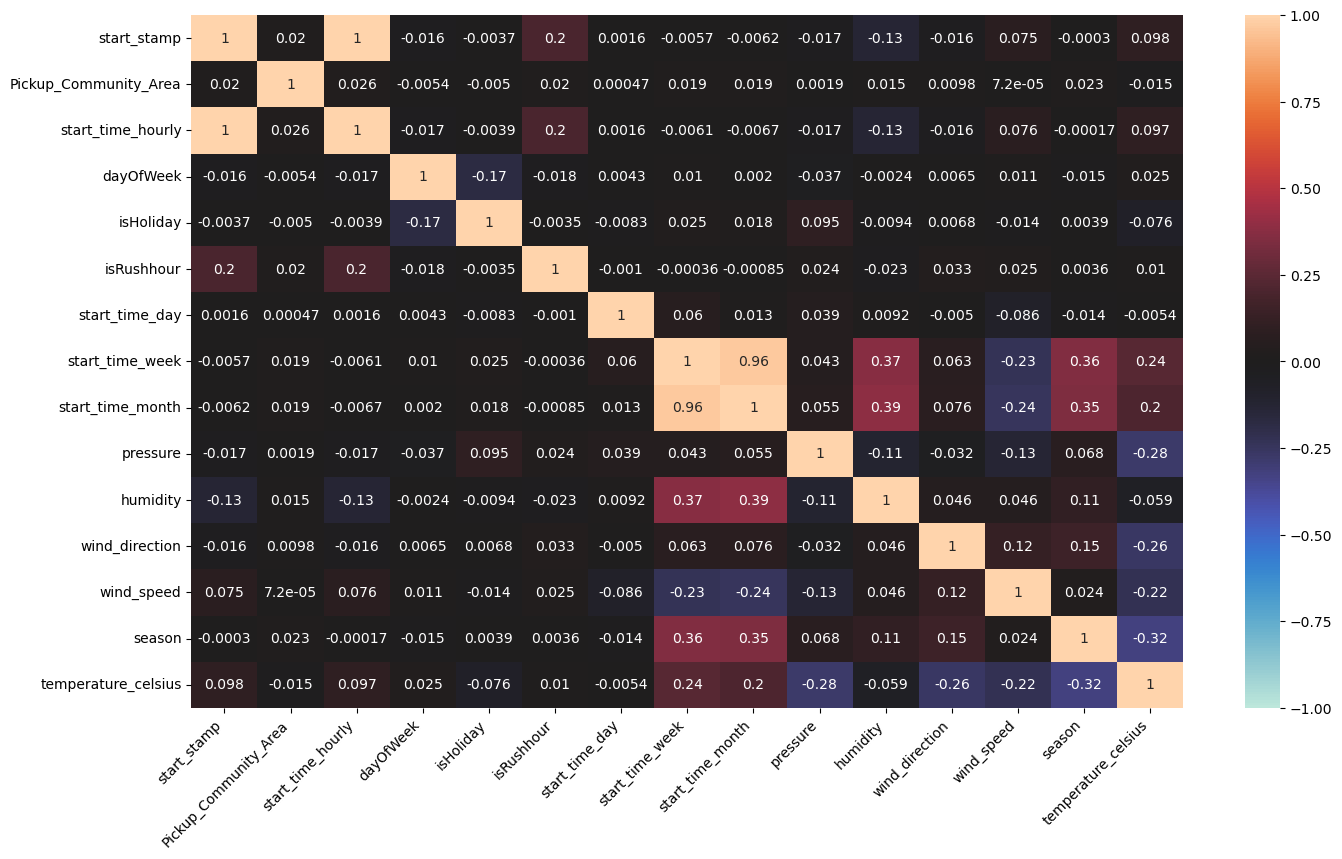

In [8]:
# correlation matrix of df_2h_comar

import seaborn as sns
corr = df_2h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

We have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`. In addition to that we have a perfect correlation between `start_time_hourly` and `start_stamp` (because we look at 2-hourly data and `start_stamp` represents the start of the interval). So we drop `start_time_hourly`, because we are interested in the 2-hourly interval (which start is represented by `start_stamp`):

In [9]:
df_2h_comar.drop(columns = ['start_time_month'],inplace = True)

In [10]:
df_2h_comar.drop(columns = ['start_time_hourly'],inplace = True)

Doing the same for the dataframes of:

- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

In [11]:
df_2h_hexlow.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_2h_hexmed.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_2h_hexhig.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)

<hr style="border: 1px solid #8888;">

## General functions

In [12]:
# Calculate Metrics
def evaluate_performance(y_test,pred_ann,df):
    print("MODEL SCORES")
    print("MAE:", round(mean_absolute_error(y_test,pred_ann), 4))
    print("MSE:", round(mean_squared_error(y_test, pred_ann), 4))
    print("RMSE:", round(mean_squared_error(y_test,pred_ann)**0.5, 4))
    print("MAPE:", round(mean_absolute_percentage_error(y_test,pred_ann), 4))
    print("Rough Accuracy Approximation:", round((1-(mean_absolute_error(y_test,pred_ann)/df["numOfTaxis_area"].mean()))*100,2), "%")
    print("R2:", round(r2_score(y_test,pred_ann)*100, 2), "%")
    print("Max Residual Error:", round(max_error(y_test,pred_ann), 4))

<hr style="border: 1px solid #8888;">

## 1. 2-Hourly Demand - Community Area

- Before running you have to install tensorflow: `pip install tensorflow`

### **Feature engineering**

Here we will shortly create dummy variables and split the data and normalize it

In [13]:
df_2h_comar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136463 entries, 0 to 136462
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   start_stamp            136463 non-null  int64  
 1   Pickup_Community_Area  136463 non-null  float64
 2   numOfTaxis_area        136463 non-null  int64  
 3   dayOfWeek              136463 non-null  int64  
 4   isHoliday              136463 non-null  bool   
 5   isRushhour             136463 non-null  bool   
 6   start_time_day         136463 non-null  int64  
 7   start_time_week        136463 non-null  int64  
 8   pressure               136463 non-null  float64
 9   humidity               136463 non-null  float64
 10  wind_direction         136463 non-null  float64
 11  wind_speed             136463 non-null  float64
 12  description            136463 non-null  object 
 13  season                 136463 non-null  int64  
 14  temperature_celsius    136463 non-nu

In [14]:
# Prepare variables for dummy creation
df_2h_comar['start_stamp'] = df_2h_comar['start_stamp'].astype(str)
df_2h_comar['Pickup_Community_Area'] = df_2h_comar['Pickup_Community_Area'].astype(str)
df_2h_comar['dayOfWeek'] = df_2h_comar['dayOfWeek'].astype(str)
df_2h_comar['start_time_day'] = df_2h_comar['start_time_day'].astype(str)
df_2h_comar['start_time_week'] = df_2h_comar['start_time_week'].astype(str)
df_2h_comar['season'] = df_2h_comar['season'].astype(str)
df_2h_comar['description'] = df_2h_comar['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_2h_comar = pd.get_dummies(df_2h_comar)
df_2h_comar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136463 entries, 0 to 136462
Columns: 215 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(207)
memory usage: 33.4 MB


In [15]:
df_2h_comar

,numOfTaxis_area,isHoliday,isRushhour,pressure,humidity,wind_direction,wind_speed,temperature_celsius,start_stamp_0,start_stamp_10,...,description_snow,description_thunderstorm,description_thunderstorm with heavy rain,description_thunderstorm with light rain,description_thunderstorm with rain,description_very heavy rain,season_0,season_1,season_2,season_3
0,15,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
1,4,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
2,123,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
3,50,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
4,67,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136458,2,False,False,1023.0,89.0,217.0,1.0,-11.00,0,0,...,0,0,0,0,0,0,0,1,0,0
136459,4,False,False,1026.0,89.0,241.0,1.0,-11.24,0,0,...,1,0,0,0,0,0,0,1,0,0
136460,1,False,False,1023.0,89.0,217.0,1.0,-11.00,0,0,...,0,0,0,0,0,0,0,1,0,0
136461,12,False,False,1026.0,89.0,241.0,1.0,-11.24,0,0,...,1,0,0,0,0,0,0,1,0,0


In [16]:
# Set output frame and input frame
x = df_2h_comar.drop('numOfTaxis_area', axis=1)
y = df_2h_comar['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

<hr style="border: 0.5px solid #8888;">

### Exploration of the model: Checking for the best Neural Network Architecture
- Exploration: We will start with some very simple Neural Network designs and gradually increase its complexity by adding more layers and nodes
- Later we will just use the Hyperband tuning algorithm, which is similar to Gridsearch, to do this work for us and decide for the best hyperparameters

#### Exploration: Very Simple Neural Network (1 Hidden Layer with 1 Node)

In [17]:
# Input Layer
inputs = keras.Input(shape=(214,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(1, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [18]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
    )

In [19]:
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
2133/2133 [==============================] - 2s 897us/step - loss: 32547.3594 - val_loss: 28441.3906
Epoch 2/100
2133/2133 [==============================] - 2s 841us/step - loss: 22400.7578 - val_loss: 19383.9219
Epoch 3/100
2133/2133 [==============================] - 2s 839us/step - loss: 16176.7021 - val_loss: 15015.9033
Epoch 4/100
2133/2133 [==============================] - 2s 859us/step - loss: 12985.6348 - val_loss: 12493.7637
Epoch 5/100
2133/2133 [==============================] - 2s 836us/step - loss: 11083.3467 - val_loss: 10977.0469
Epoch 6/100
2133/2133 [==============================] - 2s 824us/step - loss: 9984.7021 - val_loss: 10102.8916
Epoch 7/100
2133/2133 [==============================] - 2s 817us/step - loss: 9370.8330 - val_loss: 9605.4072
Epoch 8/100
2133/2133 [==============================] - 2s 814us/step - loss: 9031.2783 - val_loss: 9318.5186
Epoch 9/100
2133/2133 [==============================] - 2s 874us/step - loss: 8818.6396 - val_loss: 

In [20]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_comar)

1280/1280 [==============================] - 1s 503us/step
MODEL SCORES
MAE: 37.18
MSE: 9081.7118
RMSE: 95.298
MAPE: 2.2462
Rough Accuracy Approximation: 43.47 %
R2: 71.68 %
Max Residual Error: 1866.9224


#### Exploration: Simple Neural Network (1 Hidden Layer with 8 Nodes)

In [21]:
# Input Layer
inputs = keras.Input(shape=(214,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(8, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
2133/2133 [==============================] - 2s 887us/step - loss: 26034.5645 - val_loss: 16607.6055
Epoch 2/100
2133/2133 [==============================] - 2s 863us/step - loss: 11969.8076 - val_loss: 9890.2451
Epoch 3/100
2133/2133 [==============================] - 2s 849us/step - loss: 8599.5566 - val_loss: 8352.6230
Epoch 4/100
2133/2133 [==============================] - 2s 880us/step - loss: 7654.6323 - val_loss: 7664.3252
Epoch 5/100
2133/2133 [==============================] - 2s 858us/step - loss: 7104.1943 - val_loss: 7215.3071
Epoch 6/100
2133/2133 [==============================] - 2s 852us/step - loss: 6727.3472 - val_loss: 6920.0127
Epoch 7/100
2133/2133 [==============================] - 2s 867us/step - loss: 6446.3145 - val_loss: 6699.2007
Epoch 8/100
2133/2133 [==============================] - 2s 871us/step - loss: 6223.9810 - val_loss: 6521.2290
Epoch 9/100
2133/2133 [==============================] - 2s 872us/step - loss: 6044.2734 - val_loss: 6374.504

In [22]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_comar)

1280/1280 [==============================] - 1s 508us/step
MODEL SCORES
MAE: 22.8893
MSE: 4569.8848
RMSE: 67.6009
MAPE: 1.4775
Rough Accuracy Approximation: 65.2 %
R2: 85.75 %
Max Residual Error: 5121.4438


#### Exploration: Neural Network (1 Hidden Layer with 512 Nodes)

In [23]:
# Input Layer
inputs = keras.Input(shape=(214,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(512, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
2133/2133 [==============================] - 3s 1ms/step - loss: 10778.1865 - val_loss: 6967.4053
Epoch 2/100
2133/2133 [==============================] - 3s 1ms/step - loss: 5501.7158 - val_loss: 5873.3584
Epoch 3/100
2133/2133 [==============================] - 3s 1ms/step - loss: 3690.0369 - val_loss: 5574.5977
Epoch 4/100
2133/2133 [==============================] - 3s 1ms/step - loss: 2593.3596 - val_loss: 6336.2563
Epoch 5/100
2133/2133 [==============================] - 3s 1ms/step - loss: 2005.8207 - val_loss: 8363.0664
Epoch 6/100
2133/2133 [==============================] - 3s 1ms/step - loss: 1649.1562 - val_loss: 11052.4980
Epoch 7/100
2133/2133 [==============================] - 3s 1ms/step - loss: 1385.2457 - val_loss: 14605.1689
Epoch 8/100
2133/2133 [==============================] - 3s 1ms/step - loss: 1202.0996 - val_loss: 19007.7324
Epoch 9/100
2133/2133 [==============================] - 3s 1ms/step - loss: 1063.6860 - val_loss: 23650.5156
Epoch 10/100
2

In [24]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_comar)

1280/1280 [==============================] - 1s 611us/step
MODEL SCORES
MAE: 22.4299
MSE: 7111.0688
RMSE: 84.3272
MAPE: 1.4667
Rough Accuracy Approximation: 65.89 %
R2: 77.83 %
Max Residual Error: 7619.8198


#### Exploration: Neural Network (3 Hidden Layer with 256 Nodes)

In [25]:
# Input Layer
inputs = keras.Input(shape=(214,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
2133/2133 [==============================] - 4s 1ms/step - loss: 6194.3022 - val_loss: 4119.9351
Epoch 2/100
2133/2133 [==============================] - 3s 1ms/step - loss: 1804.2339 - val_loss: 7074.3301
Epoch 3/100
2133/2133 [==============================] - 3s 1ms/step - loss: 1095.1172 - val_loss: 5518.9321
Epoch 4/100
2133/2133 [==============================] - 3s 1ms/step - loss: 901.9955 - val_loss: 4345.5537
Epoch 5/100
2133/2133 [==============================] - 3s 1ms/step - loss: 800.5583 - val_loss: 4272.5757
Epoch 6/100
2133/2133 [==============================] - 3s 1ms/step - loss: 609.4525 - val_loss: 3540.1177
Epoch 7/100
2133/2133 [==============================] - 3s 1ms/step - loss: 579.5861 - val_loss: 5027.0127
Epoch 8/100
2133/2133 [==============================] - 3s 1ms/step - loss: 531.4949 - val_loss: 3561.3826
Epoch 9/100
2133/2133 [==============================] - 3s 1ms/step - loss: 466.9057 - val_loss: 3185.5208
Epoch 10/100
2133/2133 [=

In [26]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_comar)

1280/1280 [==============================] - 1s 676us/step
MODEL SCORES
MAE: 8.1062
MSE: 473.8195
RMSE: 21.7674
MAPE: 0.4732
Rough Accuracy Approximation: 87.67 %
R2: 98.52 %
Max Residual Error: 608.3383


#### Exploration: Complex Neural Network (8 Hidden Layer with mixed number of Nodes)

In [27]:
# Input Layer
inputs = keras.Input(shape=(214,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
2133/2133 [==============================] - 9s 4ms/step - loss: 6171.3931 - val_loss: 3578.3994
Epoch 2/100
2133/2133 [==============================] - 9s 4ms/step - loss: 2189.8259 - val_loss: 3673.3833
Epoch 3/100
2133/2133 [==============================] - 10s 4ms/step - loss: 1607.0809 - val_loss: 2090.0183
Epoch 4/100
2133/2133 [==============================] - 9s 4ms/step - loss: 1248.9313 - val_loss: 1496.1219
Epoch 5/100
2133/2133 [==============================] - 9s 4ms/step - loss: 977.4632 - val_loss: 1325.8878
Epoch 6/100
2133/2133 [==============================] - 8s 4ms/step - loss: 893.4774 - val_loss: 1132.0247
Epoch 7/100
2133/2133 [==============================] - 8s 4ms/step - loss: 766.8306 - val_loss: 792.7405
Epoch 8/100
2133/2133 [==============================] - 10s 5ms/step - loss: 658.2220 - val_loss: 719.5687
Epoch 9/100
2133/2133 [==============================] - 11s 5ms/step - loss: 587.1837 - val_loss: 692.3276
Epoch 10/100
2133/2133 [

In [28]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_comar)

1280/1280 [==============================] - 1s 996us/step
MODEL SCORES
MAE: 8.1818
MSE: 506.7202
RMSE: 22.5104
MAPE: 0.3989
Rough Accuracy Approximation: 87.56 %
R2: 98.42 %
Max Residual Error: 480.499


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model (in terms of best metric)

**Building the model with the functional API of Keras:**

In [29]:
def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(214,)) # shapesize dependent of input feature count
    
    # Hidden Layers
    ## Initialize x
    x = inputs
    
    ## Possible Hidden Layers
    for i in range(hp.Int('total_hidden_layers', 0, 10)):
        layer_name = 'hidden_layer_' + str(i+1)
        if i in [0,1,2]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[256, 512]), activation='relu')(x)
        elif i in [3,4,5]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[128, 256]), activation='relu')(x)
        elif i in [6,7,8,9]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[32, 64, 128]), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='daily_taxi_demand_chicago')
    
    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

Instantiate a tuner to perform hyperparametertuning:

The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.  
We will use `Hyperband` because the Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model.

In [30]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 10,
    factor = 3,
    executions_per_trial = 1,
    directory = os.path.normpath('C:/AAA_LOG'),
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Display search space overview:

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
total_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


Define a callback to clear the training outputs at the end of every training step:

In [32]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search:

In [33]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Trial 30 Complete [00h 00m 47s]
val_loss: 730.6519775390625

Best val_loss So Far: 709.2542114257812
Total elapsed time: 00h 12m 48s
INFO:tensorflow:Oracle triggered exit


Display the best models, their hyperparameters, and the resulting metrics:

In [34]:
tuner.results_summary()

Results summary
Results in C:\AAA_LOG\kerastuner_LOG
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0025 summary
Hyperparameters:
total_hidden_layers: 7
hidden_layer_1_units: 512
hidden_layer_2_units: 512
hidden_layer_3_units: 512
hidden_layer_4_units: 128
hidden_layer_5_units: 128
hidden_layer_6_units: 128
hidden_layer_7_units: 32
hidden_layer_8_units: 128
hidden_layer_9_units: 32
hidden_layer_10_units: 64
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 709.2542114257812

Trial 0029 summary
Hyperparameters:
total_hidden_layers: 7
hidden_layer_1_units: 256
hidden_layer_2_units: 256
hidden_layer_3_units: 512
hidden_layer_4_units: 128
hidden_layer_5_units: 256
hidden_layer_6_units: 256
hidden_layer_7_units: 32
hidden_layer_8_units: 32
hidden_layer_9_units: 32
hidden_layer_10_units: 32
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 730.6519775390625

Trial 0016 summary
Hyperparam

Get the optimal hyperparameters:

In [35]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_hidden_layers')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 512 
and the total number of hidden layers is 7.



Get the best model:

In [36]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show the model summary:

In [37]:
model_ann.summary()

Model: "daily_taxi_demand_chicago"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 214)]             0         
                                                                 
 dense (Dense)               (None, 512)               110080    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128) 

**Train the model:**

For **performance reasons**, the model was **only trained for 10 epochs** in hyperparameter tuning.  
That is why we are **now continuing to train** the model to achieve the **best possible result**.

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [38]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10, 
    restore_best_weights=True 
    )

In [39]:
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
2133/2133 [==============================] - 12s 5ms/step - loss: 576.0466 - val_loss: 767.0287
Epoch 2/100
2133/2133 [==============================] - 10s 5ms/step - loss: 754.7552 - val_loss: 670.0289
Epoch 3/100
2133/2133 [==============================] - 10s 5ms/step - loss: 416.5633 - val_loss: 925.3500
Epoch 4/100
2133/2133 [==============================] - 10s 5ms/step - loss: 415.3956 - val_loss: 682.3358
Epoch 5/100
2133/2133 [==============================] - 11s 5ms/step - loss: 380.5184 - val_loss: 660.1176
Epoch 6/100
2133/2133 [==============================] - 10s 5ms/step - loss: 380.4681 - val_loss: 830.0355
Epoch 7/100
2133/2133 [==============================] - 10s 5ms/step - loss: 318.6607 - val_loss: 765.4053
Epoch 8/100
2133/2133 [==============================] - 10s 5ms/step - loss: 315.8646 - val_loss: 699.0322
Epoch 9/100
2133/2133 [==============================] - 10s 5ms/step - loss: 282.9088 - val_loss: 548.5694
Epoch 10/100
2133/2133 [====

### Evaluation: 2-Hourly Demand - Community Area

In [40]:
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_comar)

1280/1280 [==============================] - 1s 1ms/step
MODEL SCORES
MAE: 8.3514
MSE: 536.2248
RMSE: 23.1565
MAPE: 0.4238
Rough Accuracy Approximation: 87.3 %
R2: 98.33 %
Max Residual Error: 545.3952


### NOTE:
- The architecture from this Hyperparametertuning will be used as the baseline architecture for the following spatial-unit comparisons!

<hr style="border: 0.5px solid #8888;">


## 2. 2-Hourly Demand - hexagon low resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

### **Feature engineering**

In [41]:
df_2h_hexlow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60449 entries, 0 to 60448
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_stamp          60449 non-null  int64  
 1   h3_hex_id_low_res    60449 non-null  object 
 2   numOfTaxis_area      60449 non-null  int64  
 3   dayOfWeek            60449 non-null  int64  
 4   isHoliday            60449 non-null  bool   
 5   isRushhour           60449 non-null  bool   
 6   start_time_day       60449 non-null  int64  
 7   start_time_week      60449 non-null  int64  
 8   pressure             60449 non-null  float64
 9   humidity             60449 non-null  float64
 10  wind_direction       60449 non-null  float64
 11  wind_speed           60449 non-null  float64
 12  description          60449 non-null  object 
 13  season               60449 non-null  int64  
 14  temperature_celsius  60449 non-null  float64
dtypes: bool(2), float64(5), int64(6), ob

In [42]:
# Prepare variables for dummy creation
df_2h_hexlow['start_stamp'] = df_2h_hexlow['start_stamp'].astype(str)
df_2h_hexlow['h3_hex_id_low_res'] = df_2h_hexlow['h3_hex_id_low_res'].astype(str)
df_2h_hexlow['dayOfWeek'] = df_2h_hexlow['dayOfWeek'].astype(str)
df_2h_hexlow['start_time_day'] = df_2h_hexlow['start_time_day'].astype(str)
df_2h_hexlow['start_time_week'] = df_2h_hexlow['start_time_week'].astype(str)
df_2h_hexlow['season'] = df_2h_hexlow['season'].astype(str)
df_2h_hexlow['description'] = df_2h_hexlow['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_2h_hexlow = pd.get_dummies(df_2h_hexlow)
df_2h_hexlow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60449 entries, 0 to 60448
Columns: 164 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(156)
memory usage: 11.9 MB


In [43]:
# Set output frame and input frame
x = df_2h_hexlow.drop('numOfTaxis_area', axis=1)
y = df_2h_hexlow['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [44]:
# Input Layer
inputs = keras.Input(shape=(163,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
945/945 [==============================] - 5s 5ms/step - loss: 36315.0508 - val_loss: 14666.4883
Epoch 2/100
945/945 [==============================] - 4s 4ms/step - loss: 10606.9365 - val_loss: 7384.5107
Epoch 3/100
945/945 [==============================] - 4s 5ms/step - loss: 6001.5332 - val_loss: 6582.2510
Epoch 4/100
945/945 [==============================] - 4s 4ms/step - loss: 4397.9165 - val_loss: 13003.5068
Epoch 5/100
945/945 [==============================] - 4s 5ms/step - loss: 4093.7495 - val_loss: 5149.7563
Epoch 6/100
945/945 [==============================] - 4s 5ms/step - loss: 3994.1318 - val_loss: 7421.2183
Epoch 7/100
945/945 [==============================] - 4s 5ms/step - loss: 3237.3618 - val_loss: 4539.7271
Epoch 8/100
945/945 [==============================] - 4s 4ms/step - loss: 3088.9561 - val_loss: 5096.9238
Epoch 9/100
945/945 [==============================] - 4s 5ms/step - loss: 2140.3833 - val_loss: 4894.7480
Epoch 10/100
945/945 [===========

### Evaluation: 2-Hourly Demand - hexagon low resolution

In [45]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_hexlow)

567/567 [==============================] - 1s 1ms/step
MODEL SCORES
MAE: 15.8938
MSE: 2266.8007
RMSE: 47.6109
MAPE: 0.4583
Rough Accuracy Approximation: 89.29 %
R2: 98.51 %
Max Residual Error: 1679.049


<hr style="border: 0.5px solid #8888;">


## 3. 2-Hourly Demand - hexagon medium resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

In [46]:
df_2h_hexmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162765 entries, 0 to 162764
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   start_stamp           162765 non-null  int64  
 1   h3_hex_id_medium_res  162765 non-null  object 
 2   numOfTaxis_area       162765 non-null  int64  
 3   dayOfWeek             162765 non-null  int64  
 4   isHoliday             162765 non-null  bool   
 5   isRushhour            162765 non-null  bool   
 6   start_time_day        162765 non-null  int64  
 7   start_time_week       162765 non-null  int64  
 8   pressure              162765 non-null  float64
 9   humidity              162765 non-null  float64
 10  wind_direction        162765 non-null  float64
 11  wind_speed            162765 non-null  float64
 12  description           162765 non-null  object 
 13  season                162765 non-null  int64  
 14  temperature_celsius   162765 non-null  float64
dtype

In [47]:
# Prepare variables for dummy creation
df_2h_hexmed['start_stamp'] = df_2h_hexmed['start_stamp'].astype(str)
df_2h_hexmed['h3_hex_id_medium_res'] = df_2h_hexmed['h3_hex_id_medium_res'].astype(str)
df_2h_hexmed['dayOfWeek'] = df_2h_hexmed['dayOfWeek'].astype(str)
df_2h_hexmed['start_time_day'] = df_2h_hexmed['start_time_day'].astype(str)
df_2h_hexmed['start_time_week'] = df_2h_hexmed['start_time_week'].astype(str)
df_2h_hexmed['season'] = df_2h_hexmed['season'].astype(str)
df_2h_hexmed['description'] = df_2h_hexmed['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_2h_hexmed = pd.get_dummies(df_2h_hexmed)
df_2h_hexmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162765 entries, 0 to 162764
Columns: 237 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(229)
memory usage: 43.3 MB


In [48]:
# Set output frame and input frame
x = df_2h_hexmed.drop('numOfTaxis_area', axis=1)
y = df_2h_hexmed['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [49]:
# Input Layer
inputs = keras.Input(shape=(236,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
2544/2544 [==============================] - 12s 5ms/step - loss: 4922.2280 - val_loss: 1934.4812
Epoch 2/100
2544/2544 [==============================] - 12s 5ms/step - loss: 1563.7820 - val_loss: 1605.3203
Epoch 3/100
2544/2544 [==============================] - 11s 4ms/step - loss: 1111.8367 - val_loss: 1043.5261
Epoch 4/100
2544/2544 [==============================] - 12s 5ms/step - loss: 932.4936 - val_loss: 1160.5991
Epoch 5/100
2544/2544 [==============================] - 11s 4ms/step - loss: 729.5049 - val_loss: 904.9388
Epoch 6/100
2544/2544 [==============================] - 11s 4ms/step - loss: 594.6277 - val_loss: 654.6049
Epoch 7/100
2544/2544 [==============================] - 12s 5ms/step - loss: 564.6270 - val_loss: 862.4691
Epoch 8/100
2544/2544 [==============================] - 12s 5ms/step - loss: 458.3738 - val_loss: 1358.5320
Epoch 9/100
2544/2544 [==============================] - 12s 5ms/step - loss: 447.3773 - val_loss: 622.0980
Epoch 10/100
2544/25

### Evaluation: 2-Hourly Demand - hexagon medium resolution

In [50]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_hexmed)

1526/1526 [==============================] - 2s 1ms/step
MODEL SCORES
MAE: 7.5549
MSE: 424.4344
RMSE: 20.6018
MAPE: 0.4768
Rough Accuracy Approximation: 86.3 %
R2: 98.45 %
Max Residual Error: 834.7964


<hr style="border: 0.5px solid #8888;">


## 4. 2-Hourly Demand - hexagon high resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

In [51]:
df_2h_hexhig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328844 entries, 0 to 328843
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   start_stamp          328844 non-null  int64  
 1   h3_hex_id_high_res   328844 non-null  object 
 2   numOfTaxis_area      328844 non-null  int64  
 3   dayOfWeek            328844 non-null  int64  
 4   isHoliday            328844 non-null  bool   
 5   isRushhour           328844 non-null  bool   
 6   start_time_day       328844 non-null  int64  
 7   start_time_week      328844 non-null  int64  
 8   pressure             328844 non-null  float64
 9   humidity             328844 non-null  float64
 10  wind_direction       328844 non-null  float64
 11  wind_speed           328844 non-null  float64
 12  description          328844 non-null  object 
 13  season               328844 non-null  int64  
 14  temperature_celsius  328844 non-null  float64
dtypes: bool(2), float

In [52]:
# Prepare variables for dummy creation
df_2h_hexhig['start_stamp'] = df_2h_hexhig['start_stamp'].astype(str)
df_2h_hexhig['h3_hex_id_high_res'] = df_2h_hexhig['h3_hex_id_high_res'].astype(str)
df_2h_hexhig['dayOfWeek'] = df_2h_hexhig['dayOfWeek'].astype(str)
df_2h_hexhig['start_time_day'] = df_2h_hexhig['start_time_day'].astype(str)
df_2h_hexhig['start_time_week'] = df_2h_hexhig['start_time_week'].astype(str)
df_2h_hexhig['season'] = df_2h_hexhig['season'].astype(str)
df_2h_hexhig['description'] = df_2h_hexhig['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_2h_hexhig = pd.get_dummies(df_2h_hexhig)
df_2h_hexhig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328844 entries, 0 to 328843
Columns: 420 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(412)
memory usage: 144.9 MB


In [53]:
# Set output frame and input frame
x = df_2h_hexhig.drop('numOfTaxis_area', axis=1)
y = df_2h_hexhig['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [54]:
# Input Layer
inputs = keras.Input(shape=(419,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
5139/5139 [==============================] - 26s 5ms/step - loss: 612.9703 - val_loss: 220.5158
Epoch 2/100
5139/5139 [==============================] - 25s 5ms/step - loss: 225.1233 - val_loss: 170.4032
Epoch 3/100
5139/5139 [==============================] - 25s 5ms/step - loss: 172.1950 - val_loss: 142.1310
Epoch 4/100
5139/5139 [==============================] - 26s 5ms/step - loss: 143.6894 - val_loss: 146.2006
Epoch 5/100
5139/5139 [==============================] - 25s 5ms/step - loss: 118.9236 - val_loss: 112.8749
Epoch 6/100
5139/5139 [==============================] - 25s 5ms/step - loss: 106.3985 - val_loss: 112.2659
Epoch 7/100
5139/5139 [==============================] - 25s 5ms/step - loss: 93.0597 - val_loss: 140.5948
Epoch 8/100
5139/5139 [==============================] - 25s 5ms/step - loss: 86.2334 - val_loss: 120.0468
Epoch 9/100
5139/5139 [==============================] - 26s 5ms/step - loss: 78.8590 - val_loss: 108.3371
Epoch 10/100
5139/5139 [=======

### Evaluation: 2-Hourly Demand - hexagon high resolution

In [55]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_2h_hexhig)

3083/3083 [==============================] - 3s 1ms/step
MODEL SCORES
MAE: 4.7385
MSE: 94.6747
RMSE: 9.7301
MAPE: 0.522
Rough Accuracy Approximation: 82.64 %
R2: 97.39 %
Max Residual Error: 321.3836


Done